## TME 2

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from statistics import median
from sklearn.linear_model import LinearRegression

plt.ion()
parismap = mpimg.imread('data/paris-48.806-2.23--48.916-2.48.jpg')

## coordonnees GPS de la carte
xmin,xmax = 2.23,2.48   ## coord_x min et max
ymin,ymax = 48.806,48.916 ## coord_y min et maxdef show_map():

In [130]:
def show_map():
    plt.imshow(parismap,extent=[xmin,xmax,ymin,ymax],aspect=1.5)
    ## extent pour controler l'echelle du plan

def getHistogram(pas,xmin,xmax,ymin,ymax):
    arrayX=np.linspace(xmin,xmax,pas)
    arrayY=np.linspace(ymin,ymax,pas)
    return arrayX,arrayY

def fillHistogram(arrayX,arrayY,geomat):
    n=len(arrayX)
    m=len(arrayY)
    mat=np.zeros((m,n))
    for coord in geomat:
        x=coord[1]
        y=coord[0]
        for i in range(n):
            if (arrayX[i]>x):
                posX=i
                break
        for i in range(m):
            if (arrayY[i]>y):
                posY=i
                break
        mat[posY,posX]+=1
    return mat

def show_histogram(geo_mat,steps,xmin,xmax,ymin,ymax):
    a, b = getHistogram(steps,xmin,xmax,ymin,ymax)
    res = fillHistogram(a, b, geo_mat)
    plt.figure()
    show_map()
    res /= sum(sum(res))
    plt.scatter(geo_mat[:, 1], geo_mat[:, 0], alpha=0.2, s=3,c="blue",label=typepoi)
    plt.legend()
    plt.title("Méthode des histogrammes avec une discrétisation en {} intervalles".format(steps))
    plt.imshow(res, extent=[xmin, xmax, ymin, ymax], interpolation='none', \
               alpha=0.3, origin="lower")
    plt.colorbar()

Liste des types de POI furniture_store, laundry, bakery, cafe, home_goods_store, clothing_store, atm, lodging, night_club, convenience_store, restaurant, bar
556 points d'intérêt trouvés


Text(0.5, 1.0, 'Affichage des POI')

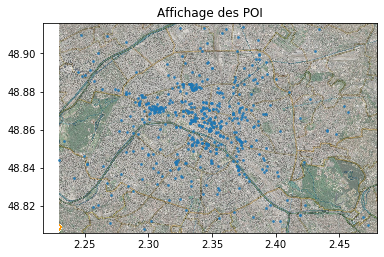

In [18]:
poidata = pickle.load(open("data/poi-paris.pkl","rb"))
## liste des types de point of interest (poi)
print("Liste des types de POI" , ", ".join(poidata.keys()))

## Choix d'un poi
typepoi = "night_club"

## Creation de la matrice des coordonnees des POI
geo_mat = np.zeros((len(poidata[typepoi]),2))
print("{} points d'intérêt trouvés".format(len(poidata[typepoi])))
"""
xmin,xmax = 2.23,2.48   ## coord_x min et max
ymin,ymax = 48.806,48.916 ## coord_y min et max"""
for i,(k,v) in enumerate(poidata[typepoi].items()):
    geo_mat[i,:]=v[0]

## Affichage brut des poi
show_map()
## alpha permet de regler la transparence, s la taille
plt.scatter(geo_mat[:,1],geo_mat[:,0],alpha=0.8,s=3)
plt.title("Affichage des POI")

# Méthode des histogrammes

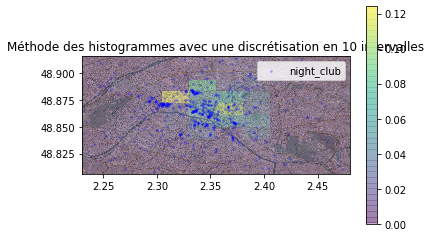

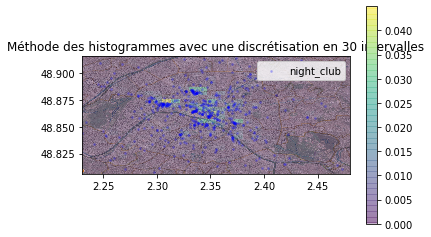

In [134]:
# discretisation pour l'affichage des modeles d'estimation de densite
steps = 30
xx,yy = np.meshgrid(np.linspace(xmin,xmax,steps),np.linspace(ymin,ymax,steps))
grid = np.c_[xx.ravel(),yy.ravel()]

# A remplacer par res = monModele.predict(grid).reshape(steps,steps)
show_histogram(geo_mat,10,xmin,xmax,ymin,ymax)
show_histogram(geo_mat,30,xmin,xmax,ymin,ymax)

La méthode des histogrammes est très sensible à de petites variations de pas (les voisins les plus proches d'un point ne sont pas forcément dans la même case que ce point). 

Une faible discrétisation apporte peu d'informations et n'est pas précise tandis qu'une forte discrétisation fait apparaître de nombreuses discontinuités.

Pour résoudre cela, on implémente la méthode des noyaux: Pour un point *x* donné situé dans une case **c**, plutôt que de regarder le nombre de points dans la case **c**, on applique une fonction continue sur tous les points situés dans une petite fenêtre autour du point *x*, cela est censé résoudre la sensibilité aux variations de pas causée par la discrétisation

Le rôle du paramètre $h_{n}$ des méthodes à noyaux est de choisir la taille de la fenêtre évoquée ci-dessus. La taille de cette fenêtre définira la taille d'un voisinage

# Méthode des noyaux

In [22]:
def split(data,percentage):
    if percentage<=0 or percentage>=1:
        return
    np.random.shuffle(data)
    coupe=int(len(data)*percentage)
    datatrain=data[:coupe]
    datatest=data[coupe:]
    return datatrain,datatest

def splitWithLabel(data,labels,percentage):
    if percentage<=0 or percentage>=1:
        return
    c = list(zip(data, labels))
    np.random.shuffle(c)
    data, labels = zip(*c)
    coupe=int(len(data)*percentage)
    datatrain=data[:coupe]
    datatest=data[coupe:]
    labelstrain = labels[:coupe]
    labelstest = labels[coupe:]
    return datatrain,labelstrain,datatest,labelstest

In [23]:
def gaussianKernel(vect):
    return np.prod((1/np.sqrt(2*np.pi))*np.exp(-0.5*vect**2),axis=0)

def epanechikovKernel(vect):
    res=1
    for coord in vect:
        res*=0.75*max(0,1-coord**2)
    return res

def laplaceKernel(vect):
    return np.prod(0.5*np.exp(-1*abs(vect)))

def uniformKernel(vect):
    res=1
    for coord in vect:
        if (abs(coord)<=1):
            res*=0.5
        else:
            return 0
    return res


In [115]:
def fillMatrix(grid,geomat,func,hn):
    n=len(geomat)
    mat=np.zeros((len(grid)))
    for i in range(len(grid)):
        elt = np.array([grid[i][1],grid[i][0]])
        for coord in geomat:
            val=func((coord-elt)/hn)
            mat[i] += val
        mat[i] *= 1/(n*hn)
    mat /= sum(mat)
    return mat

def findCoordinates(arrayX,arrayY,point):
    pointx=point[1]
    pointy=point[0]
    steps = len(arrayX)
    x=steps-1
    y=steps-1
    for i in range(steps):
        elt = arrayX[i]
        if elt>pointx:
            x = i
            break
    for i in range(steps):
        elt = arrayY[i]
        if elt>pointy:
            y = i
            break
    return (y,x)

def computeMatrix(grid,geomatTrain,func,hn,steps):
    mat = np.zeros((len(grid)))
    n = len(geomatTrain)
    for i in range(len(grid)):
        elt = np.array([grid[i][1], grid[i][0]])
        for coord in geomatTrain:
            mat[i] += func((coord - elt) / hn)
        mat[i] *= 1 / (n * hn)
    mat = mat.reshape((steps, steps))
    if (sum(sum(mat)) != 0 ):
        mat /= sum(sum(mat))
    return mat

def computeLikelihood(mat,geomatTest,arrayX,arrayY): #geomat devient testSet
    loglikelihood=0
    for elt in geomatTest:
        (x,y) = findCoordinates(arrayX,arrayY,elt)
        val = mat[x][y]
        #print("elt: {}, x:{}, y:{}, val: {}".format(elt, x, y,val))
        if val == 0:
            loglikelihood += np.log(0.000000001)
        else:
            loglikelihood += np.log(val)
    return loglikelihood

def show_kernel_map(geo_mat,func,hn,steps):
    xx, yy = np.meshgrid(np.linspace(xmin, xmax, steps), np.linspace(ymin, ymax, steps))
    grid = np.c_[xx.ravel(), yy.ravel()]
    mat = fillMatrix(grid,geo_mat, func, hn)
    mat = mat.reshape((steps, steps))
    mat /= sum(sum(mat))
    plt.figure()
    show_map()
    plt.scatter(geo_mat[:, 1], geo_mat[:, 0], alpha=0.4, s=3,label=typepoi)
    plt.legend()
    plt.title("Méthode des noyaux, noyau: {}, hn: {}".format(func.__name__,hn))
    plt.imshow(mat, extent=[xmin, xmax, ymin, ymax], interpolation='none', alpha=0.3, origin="lower")
    return

In [118]:
def gridSearchHn(arrayHn,geo_mat,folds,func,steps):
    xx, yy = np.meshgrid(np.linspace(xmin, xmax, steps), np.linspace(ymin, ymax, steps))
    grid = np.c_[xx.ravel(), yy.ravel()]
    arrayScores = []
    arrayX = np.linspace(xmin, xmax, steps)
    arrayY = np.linspace(ymin, ymax, steps)
    for hn in arrayHn:
        likelihood = 0
        for i in range(folds):
            geomatTrain, geomatTest = split(geo_mat, 0.7)
            mat = computeMatrix(grid, geomatTrain, func, hn,steps)
            likelihood += computeLikelihood(mat,geomatTest,arrayX,arrayY)
        likelihood /= folds
        print("hn: {}, log-vraisemblance1: {:0.2f}".format(hn, likelihood))
        arrayScores.append(likelihood)
    for k in range(3):
        likelihood = 0
        arraySorted = np.argsort(-1 * np.array(arrayScores))
        bestHn = arrayHn[arraySorted[0]]
        secondBestHn = arrayHn[arraySorted[1]]
        print("Les deux meilleurs hn sont: {} et {}".format(bestHn, secondBestHn))
        newHn = (bestHn + secondBestHn) / 2
        if newHn in arrayHn:
            continue
        print("Test avec newHn = {}".format(newHn))
        arrayHn = np.append(arrayHn,newHn)
        for i in range(folds):
            geomatTrain, geomatTest = split(geo_mat, 0.7)
            mat = computeMatrix(grid, geomatTrain, func, newHn,steps)
            likelihood += computeLikelihood(mat, geomatTest, arrayX, arrayY)
        likelihood /= folds
        print("hn: {}, log-vraisemblance2: {:0.2f}".format(newHn, likelihood))
        arrayScores.append(likelihood)
    bestHn = arrayHn[arrayScores.index(max(arrayScores))]
    print("Maximum de vraisemblance trouvé pour hn={}".format(bestHn))
    show_kernel_map(geo_mat, func, bestHn, steps)
    plt.show()

On affiche maintenant la heatmap avec les différents noyaux pour hn=0.005

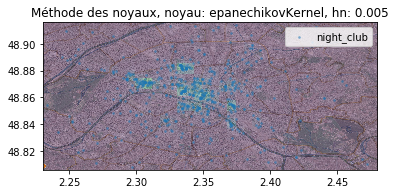

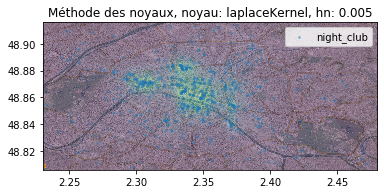

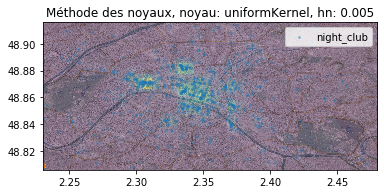

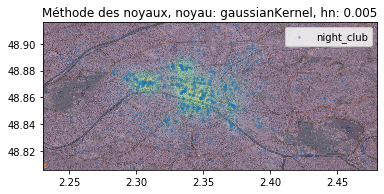

In [47]:
show_kernel_map(geo_mat, epanechikovKernel, 0.005, 40)
show_kernel_map(geo_mat, laplaceKernel, 0.005, 40)
show_kernel_map(geo_mat, uniformKernel, 0.005, 40)
show_kernel_map(geo_mat, gaussianKernel, 0.005, 40)

On cherche maintenant à optimiser le paramètre **$h_{n}$**
Pour cela, on utilise un maximum de vraisemblance en divisant les données en un ensemble d'entraînement et un ensemble de test plutôt qu'une optimisation sur les données complètes qui poserait problème

En effet, plus Hn est grand et plus le terme $\frac{x-x_{i}}{h_{n}}$ est petit ce qui implique que la vraisemblance est maximale lorsque $h_{n}$ est grand par définition de la fonction noyau (qui atteint son maximum en 0)

hn: 0.0001, log-vraisemblance1: -26722.19
hn: 0.000325, log-vraisemblance1: -11698.25
hn: 0.00055, log-vraisemblance1: -6139.08
hn: 0.0007750000000000001, log-vraisemblance1: -3304.95
hn: 0.001, log-vraisemblance1: -2762.36
hn: 0.002, log-vraisemblance1: -1429.05
hn: 0.003, log-vraisemblance1: -1136.04
hn: 0.004, log-vraisemblance1: -1071.22
hn: 0.005, log-vraisemblance1: -1075.88
hn: 0.006, log-vraisemblance1: -1043.85
hn: 0.007, log-vraisemblance1: -1057.07
hn: 0.008, log-vraisemblance1: -1062.12
hn: 0.009000000000000001, log-vraisemblance1: -1063.52
hn: 0.01, log-vraisemblance1: -1069.59
hn: 0.02, log-vraisemblance1: -1088.44
hn: 0.04, log-vraisemblance1: -1129.23
hn: 0.06, log-vraisemblance1: -1161.50
hn: 0.08, log-vraisemblance1: -1184.53
hn: 0.1, log-vraisemblance1: -1197.46
hn: 0.2, log-vraisemblance1: -1222.20
hn: 0.6000000000000001, log-vraisemblance1: -1230.92
hn: 1.0, log-vraisemblance1: -1231.67
Les deux meilleurs hn sont: 0.006 et 0.007
Test avec newHn = 0.0065000000000000

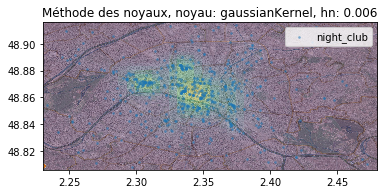

In [125]:
arrayHn = np.concatenate((np.linspace(0.0001,0.001,5),np.linspace(0.002,0.01,9),np.linspace(0.02,0.1,5),np.linspace(0.2,1,3)))
gridSearchHn(arrayHn,geo_mat,5,gaussianKernel,40)

Le paramètre **steps** (nombre d'intervalles dans la discrétisation de l'espace) a une grande influence sur le gridSearch pour l'optimisation du paramètre Hn, un **steps** petit renvoie de mauvais résultats (on voit clairement la discrétisation de l'espace à l'oeil nu et la heatmap ressemble à une méthode des histogrammes) tandis qu'un **steps** trop grand augmente fortement le temps d'exécution du plot. Il faut donc trouver un compromis entre les deux.

Voici une illustration du gridSearch avec un **steps** faible (steps=10)

hn: 0.0001, log-vraisemblance1: -27887.05
hn: 0.000325, log-vraisemblance1: -14407.05
hn: 0.00055, log-vraisemblance1: -6170.66
hn: 0.0007750000000000001, log-vraisemblance1: -4406.10
hn: 0.001, log-vraisemblance1: -2632.70
hn: 0.002, log-vraisemblance1: -1226.84
hn: 0.003, log-vraisemblance1: -934.81
hn: 0.004, log-vraisemblance1: -695.02
hn: 0.005, log-vraisemblance1: -672.71
hn: 0.006, log-vraisemblance1: -694.80
hn: 0.007, log-vraisemblance1: -673.23
hn: 0.008, log-vraisemblance1: -634.24
hn: 0.009000000000000001, log-vraisemblance1: -633.52
hn: 0.01, log-vraisemblance1: -625.64
hn: 0.02, log-vraisemblance1: -631.96
hn: 0.04, log-vraisemblance1: -662.88
hn: 0.06, log-vraisemblance1: -696.89
hn: 0.08, log-vraisemblance1: -714.91
hn: 0.1, log-vraisemblance1: -731.01
hn: 0.2, log-vraisemblance1: -757.86
hn: 0.6000000000000001, log-vraisemblance1: -767.73
hn: 1.0, log-vraisemblance1: -768.58
Les deux meilleurs hn sont: 0.01 et 0.02
Test avec newHn = 0.015
hn: 0.015, log-vraisemblance2:

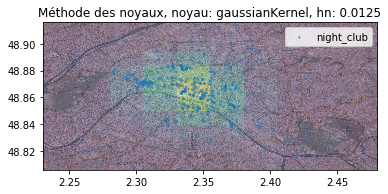

In [120]:
gridSearchHn(arrayHn,geo_mat,5,gaussianKernel,10)

# Estimateur de Nadaraya-Watson
On cherche maintenant à prédire la note d'un point d'intérêt. Pour cela, on implémente l'estimateur de Nadaraya-Watson en répartissant les données en deux classes équilibrées: La classe négative contient tous les POI dont la note est inférieure à la médiane des notes, la classe positive contient les POI ayant une note supérieure ou égale à cette même médiane. <br>
De cette façon, on s'assure que les deux classes sont bien équilibrées.

In [32]:
def getPoiMarks(poidata, typepoi):
    geo_mat_clean = []
    notes = []
    arrLabels = []
    for i,(k,v) in enumerate(poidata[typepoi].items()):
        note = v[1]
        if note != -1:
            geo_mat_clean.append(np.array(v[0]))
            notes.append(note)
    moy = median(notes)
    for note in notes:
        if note < moy:
            arrLabels.append(-1)
        else:
            arrLabels.append(1)
    arrLabels=np.array(arrLabels)
    return geo_mat_clean, arrLabels

def calcProba(x,func,arrLabels,geo_mat_clean,hn):
    num=0
    for i in range(len(arrLabels)):
        poi = geo_mat_clean[i]
        label = arrLabels[i]
        num += label*func((x-poi)/hn)
    return num

def bestHnForNadarayaClassification(geo_mat_clean,arrLabels,func):
    arrayAcc=np.zeros(len(arrayHn))
    for k in range(5):
        dataTrain,labelsTrain,dataTest,labelsTest = splitWithLabel(geo_mat_clean,arrLabels,0.7)
        dataTrain = np.array(dataTrain)
        for j in range(len(arrayHn)):
            hn = arrayHn[j]
            cpt = 0
            for i in range(len(dataTest)):
                elt = dataTest[i]
                label = np.sign(calcProba(np.array(elt), func, labelsTrain, dataTrain,hn))
                if label == labelsTest[i]:
                    cpt +=1
            arrayAcc[j]+=cpt/len(dataTest)

    arrayAcc = np.array(arrayAcc)
    arrayAcc /= 5
    for i in range(len(arrayAcc)):
        print("hn: {}, accuracy: {:0.2f}".format(arrayHn[i],arrayAcc[i]))
    bestHn = arrayHn[np.argsort(arrayAcc*-1)[0]]
    return bestHn

def plotClassification(geo_mat_clean,arrLabels,hn):
    dataTrain,labelsTrain,dataTest,labelsTest = splitWithLabel(geo_mat_clean,arrLabels,0.7)
    pos = []
    neg = []
    for elt in grid:
        x = np.array([elt[1], elt[0]])
        a = calcProba(x, gaussianKernel, labelsTrain, dataTrain, hn)
        if (a > 0):
            pos.append(x)
        else:
            neg.append(x)
    pos = np.array(pos)
    neg = np.array(neg)
    plt.figure()
    show_map()
    plt.scatter(pos[:, 1], pos[:, 0], alpha=0.8, s=3, label="Classe positive")
    plt.scatter(neg[:, 1], neg[:, 0], alpha=0.8, s=3, c="orange", label="Classe négative")
    plt.title("hn: "+str(hn))
    plt.legend()
    plt.show()


On effectue maintenant un gridSearch pour chercher la meilleure valeur de $h_{n}$ en utilisant la mesure d'accuracy. <br>
On entraîne ensuite notre modèle sur un ensemble d'entraînement et on essaye de prédire les notes de tous les points de l'espace discrétisé.

hn: 0.0001, accuracy: 0.09242424242424244
hn: 0.000325, accuracy: 0.2166666666666667
hn: 0.00055, accuracy: 0.24848484848484848
hn: 0.0007750000000000001, accuracy: 0.2818181818181818
hn: 0.001, accuracy: 0.3181818181818182
hn: 0.002, accuracy: 0.4045454545454545
hn: 0.003, accuracy: 0.4636363636363637
hn: 0.004, accuracy: 0.5121212121212121
hn: 0.005, accuracy: 0.5181818181818182
hn: 0.006, accuracy: 0.5212121212121212
hn: 0.007, accuracy: 0.5106060606060605
hn: 0.008, accuracy: 0.5136363636363637
hn: 0.009000000000000001, accuracy: 0.5121212121212121
hn: 0.01, accuracy: 0.5151515151515151
hn: 0.02, accuracy: 0.5
hn: 0.04, accuracy: 0.47727272727272735
hn: 0.06, accuracy: 0.4545454545454546
hn: 0.08, accuracy: 0.47727272727272735
hn: 0.1, accuracy: 0.4636363636363637
hn: 0.2, accuracy: 0.4651515151515152
hn: 0.6000000000000001, accuracy: 0.47424242424242424
hn: 1.0, accuracy: 0.47424242424242424
La meilleure accuracy est obtenue avec hn=0.006


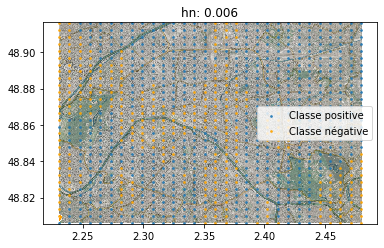

In [34]:
geo_mat_clean, arrLabels = getPoiMarks(poidata, typepoi)
bestHn = bestHnForNadarayaClassification(geo_mat_clean,arrLabels,epanechikovKernel)
print("La meilleure accuracy est obtenue avec hn={}".format(bestHn))
plotClassification(geo_mat_clean,arrLabels,bestHn)

# KNN
On cherche maintenant à prédire les notes en utilisant un KNN.
On implémente le KNN et on effectue un gridSearch pour chercher le nombre de voisins optimal à considérer

In [145]:
def euclidianDistance(x,y):
    return np.sqrt(np.sum((x-y)**2))

def knn(arrayVoisins,geo_mat_clean,arrLabels):
    arrayAcc = np.zeros(len(arrayVoisins))
    for l in range(10):
        dataTrain, labelsTrain, dataTest, labelsTest = splitWithLabel(geo_mat_clean, arrLabels, 0.7)
        dataTrain = np.array(dataTrain)
        labelsTrain = np.array(labelsTrain)
        for j in range(len(arrayVoisins)):
            maxVoisins = arrayVoisins[j]
            cpt = 0
            for i in range(len(dataTest)):
                x = dataTest[i]
                arrDistances=[]
                for k in range(len(dataTrain)): #On cherche les k plus proches voisins
                    xj = dataTrain[k]
                    arrDistances.append(euclidianDistance(x,xj))
                arrDistances = np.array(arrDistances)
                label = np.sign(np.sum(labelsTrain[np.argsort(arrDistances)[:maxVoisins]]))
                if label == labelsTest[i]:
                    cpt += 1
            arrayAcc[j] += cpt / len(dataTest)
    arrayAcc = np.array(arrayAcc)
    arrayAcc /= 10
    for i in range(len(arrayAcc)):
        print("maxVoisins: {}, accuracy: {:0.2f}".format(arrayVoisins[i], arrayAcc[i]))
    return arrayAcc
arrayVoisins = np.arange(1,20,2)
acc = knn(arrayVoisins,geo_mat_clean,arrLabels)
print("Meilleure accuracy obtenue avec {} voisins".format(arrayVoisins[np.argsort(np.array(acc)*-1)[0]]))

maxVoisins: 1, accuracy: 0.52
maxVoisins: 3, accuracy: 0.54
maxVoisins: 5, accuracy: 0.57
maxVoisins: 7, accuracy: 0.57
maxVoisins: 9, accuracy: 0.57
maxVoisins: 11, accuracy: 0.55
maxVoisins: 13, accuracy: 0.53
maxVoisins: 15, accuracy: 0.53
maxVoisins: 17, accuracy: 0.52
maxVoisins: 19, accuracy: 0.52
Meilleure accuracy obtenue avec 7 voisins


On entraîne maintenant notre modèle sur un ensemble d'entraînement et on essaye de prédire les notes de tous les points de l'espace discrétisé en prenant les 7 plus proches voisins pour chaque point.

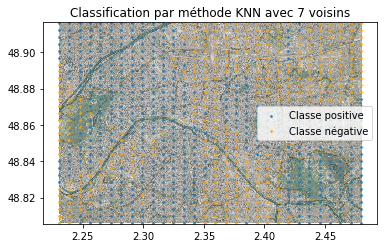

In [162]:
def calcProbaKnn(x,nbVoisins,arrLabels,geo_mat_clean):
    arrDistances = []
    for k in range(len(geo_mat_clean)):  # On cherche les k plus proches voisins
        xj = geo_mat_clean[k]
        arrDistances.append(euclidianDistance(x, xj))
    arrDistances = np.array(arrDistances)
    label = np.sign(np.sum(arrLabels[np.argsort(arrDistances)[:nbVoisins]]))
    return label

def plotClassificationKnn(geo_mat_clean,arrLabels,nbVoisins):
    dataTrain,labelsTrain,dataTest,labelsTest = splitWithLabel(geo_mat_clean,arrLabels,0.75)
    dataTrain = np.array(dataTest)
    labelsTrain = np.array(labelsTrain)
    pos = []
    neg = []
    for elt in grid:
        x = np.array([elt[1], elt[0]])
        a = calcProbaKnn(x,nbVoisins,labelsTrain,dataTrain)
        if (a > 0):
            pos.append(x)
        else:
            neg.append(x)
    pos = np.array(pos)
    neg = np.array(neg)
    plt.figure()
    show_map()
    plt.scatter(pos[:, 1], pos[:, 0], alpha=0.8, s=3, label="Classe positive")
    plt.scatter(neg[:, 1], neg[:, 0], alpha=0.8, s=3, c="orange", label="Classe négative")
    plt.title("Classification par méthode KNN avec {} voisins".format(nbVoisins))
    plt.legend()
    plt.show()

plotClassificationKnn(geo_mat_clean,arrLabels,7)